In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform
from tqdm import tqdm
from itertools import product
import pickle
from scipy.stats import binned_statistic


# Model
Idea: observe the effect of random CA3-CA1 projections in the case of low dimensional continuous attractor vs randomly projected high dimensional attractors


In [2]:
# place field activation funtion
def PlaceField(x,y,x_c,y_c,peak_act=1,pf_sigma=10): 
    x_off = (x-x_c)**2
    y_off = (y-y_c)**2
    pf_act = peak_act*np.exp(-(x_off+y_off)/(2*pf_sigma**2))
    return pf_act

# builds environmenr 
def BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1):
    X_Grid, Y_Grid = np.meshgrid(np.arange(0,L,Samp_Dens),np.arange(0,L,Samp_Dens)) 
    
    CA3_X = np.linspace(0,L,int(L/CA3_Dens)+1) 
    CA3_X = (CA3_X[0:-1]+CA3_X[1:])/2
    
    X_Pf , Y_Pf = np.meshgrid(CA3_X,CA3_X)
    
    return X_Grid, Y_Grid, X_Pf, Y_Pf, X_Pf.size

def Connections_Init(N_CA3,N_CA1):
    Conn = np.random.rand(N_CA3,N_CA1)
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    return Conn

def Compute_Sparsity(Vec):
    sp = (np.mean(Vec))**2/np.mean(Vec**2)
    return sp



def Normalize_Activity(Act,sparsity=0.1):
    th = np.percentile(Act,(1.0-sparsity)*100)
    Act = Act-th
    Act[Act<0] = 0
    Act = Act/np.mean(Act)
    return Act

def Compute_Plasticity(Pre,Post,eta=0.001):
    dw = Pre @ ((Post-np.mean(Post,axis=0)).T)
    dw = dw * eta
    return dw

def Apply_Plasticity(Conn,dw_tot):
    Conn += dw_tot
    Conn[Conn<0] = 0
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    Conn[np.isnan(Conn)] = 0
    return Conn

def Add_Noise(vector,sigma):
    vector += np.random.uniform(-sigma,sigma,size = vector.shape)
    return vector




# Noisy learning

In [46]:
eta_l = 0.0001 # LEARNING RATE
n_rounds = 10 # AMOUNT OF LEARNING

sparsitites = [0.1,0.2,0.3,0.4,0.6,0.8]
noise_levels = [0,0.1,0.5,1,2]

CA1_data = {'sparsity':[],
            'noise_level':[],
            'initial_connectivity':[],
            'trained_connectivity':[],
            'pfc_distances':[],
            'retr_correlations':[]}


for spars,noise in product(sparsitites,noise_levels):
        print(f"Computing spastity:{spars}, noise:{noise} ... ")
        CA1_data['sparsity'].append(spars)
        CA1_data['noise_level'].append(noise)
        
        # TRAINING

        X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
        XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
        XY_DD = pdist(XY_Coor)
        N_CA1 = N_CA3 * 3
        Conn = Connections_Init(N_CA3,N_CA1)
        
        CA1_data['initial_connectivity'].append(Conn)

        for l_round in range(n_rounds):
            dw_tot = 0
            #swipes the envirronment
            for zz in tqdm(range(XY_Coor.shape[0])):
                Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
                Act_XY = Add_Noise(Act_XY,sigma=noise)
                CA1_Act = Act_XY@Conn
                CA1_Time = Normalize_Activity(CA1_Act,sparsity=spars)

                Pre = Act_XY[:,np.newaxis]
                Post = CA1_Time[:,np.newaxis]

                dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

            Conn = Apply_Plasticity(Conn,dw_tot)
        
        CA1_data['trained_connectivity'].append(Conn)

        

        # TESTING: why is the initialization different?

        X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
        XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
        XY_DD = pdist(XY_Coor)
        N_CA1 = N_CA3 * 3


        CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
        for zz in range(XY_Coor.shape[0]):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            CA1_Act = Act_XY@Conn


            CA1_Out[zz,:] = Normalize_Activity(CA1_Act,sparsity=spars)


        CA1_DD = 1 - pdist(CA1_Out,metric='correlation')

        CA1_data['pfc_distances'].append(XY_DD)
        CA1_data['retr_correlations'].append(CA1_DD)


CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
XY_DD = pdist(XY_Coor)
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')

CA3_data = {'pfc_distances':XY_DD,'correlations':CA3_DD}


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0 ... 


100%|██████████| 10000/10000 [00:02<00:00, 4343.60it/s]
<ipython-input-2-d17828731205>:45: RuntimeWarning: invalid value encountered in true_divide
  Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:2 ... 


100%|██████████| 10000/10000 [00:02<00:00, 4622.15it/s]


In [47]:
# save output to file
out_file_path = 'processed_data/CA1_data_noisy_learning.pickle'
with open(out_file_path, 'wb') as handle:
    pickle.dump(CA1_data, handle)

out_file_path = 'processed_data/CA3_data_noisy_learning.pickle'
with open(out_file_path, 'wb') as handle:
    pickle.dump(CA3_data, handle)


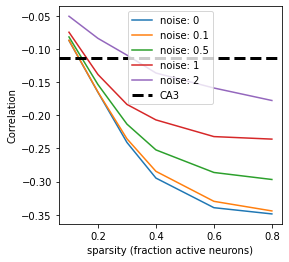

In [58]:
plt.figure(figsize=(4,4))
plt.xlabel("sparsity (fraction active neurons)")
plt.ylabel("Correlation")

for noise in noise_levels:
    idxs = np.where(np.asarray(CA1_data['noise_level'])==noise)
    sparsitites = np.asarray(CA1_data['sparsity'])[idxs]
    correlations = np.asarray(CA1_data['retr_correlations'])[idxs]
    distances = np.asarray(CA1_data['pfc_distances'])[idxs]
    binned_corr = []
    for i,CA1_DD in enumerate(correlations):
        binned_corr.append(binned_statistic(distances[i],CA1_DD,statistic='mean',bins=10)[0])
    min_corr_l = [min(i) for i in binned_corr]
    
    plt.plot(sparsitites,min_corr_l,label=f'noise: {noise}')

# CA3
binned_corr = binned_statistic(CA3_data['pfc_distances'],CA3_data['correlations'],statistic='mean',bins=10)[0]
plt.axhline(y=min(binned_corr),linestyle='--',linewidth=3,c='k',label='CA3')

plt.legend()


# Noisy retrieval

In [59]:
eta_l = 0.0001 # LEARNING RATE
n_rounds = 10 # AMOUNT OF LEARNING

sparsitites = [0.1,0.2,0.3,0.4,0.6,0.8]
noise_levels = [0,0.1,0.5,1,2]

CA1_data = {'sparsity':[],
            'noise_level':[],
            'initial_connectivity':[],
            'trained_connectivity':[],
            'pfc_distances':[],
            'retr_correlations':[]}


for spars,noise in product(sparsitites,noise_levels):
        print(f"Computing spastity:{spars}, noise:{noise} ... ")
        CA1_data['sparsity'].append(spars)
        CA1_data['noise_level'].append(noise)
        
        # TRAINING

        X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
        XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
        XY_DD = pdist(XY_Coor)
        N_CA1 = N_CA3 * 3
        Conn = Connections_Init(N_CA3,N_CA1)
        
        CA1_data['initial_connectivity'].append(Conn)

        for l_round in range(n_rounds):
            dw_tot = 0
            #swipes the envirronment
            for zz in tqdm(range(XY_Coor.shape[0])):
                Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
                CA1_Act = Act_XY@Conn
                CA1_Time = Normalize_Activity(CA1_Act,sparsity=spars)

                Pre = Act_XY[:,np.newaxis]
                Post = CA1_Time[:,np.newaxis]

                dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

            Conn = Apply_Plasticity(Conn,dw_tot)
        
        CA1_data['trained_connectivity'].append(Conn)

        

        # TESTING: why is the initialization different?

        X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
        XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
        XY_DD = pdist(XY_Coor)
        N_CA1 = N_CA3 * 3


        CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
        for zz in range(XY_Coor.shape[0]):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            Act_XY = Add_Noise(Act_XY,sigma=noise)
            CA1_Act = Act_XY@Conn


            CA1_Out[zz,:] = Normalize_Activity(CA1_Act,sparsity=spars)


        CA1_DD = 1 - pdist(CA1_Out,metric='correlation')

        CA1_data['pfc_distances'].append(XY_DD)
        CA1_data['retr_correlations'].append(CA1_DD)


CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
    Act_XY = Add_Noise(Act_XY,sigma=noise)
    CA3_Out[zz,:] = Act_XY
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')

CA3_data = {'pfc_distances':XY_DD,'correlations':CA3_DD}

  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0 ... 


100%|██████████| 10000/10000 [00:02<00:00, 4261.58it/s]
<ipython-input-2-d17828731205>:45: RuntimeWarning: invalid value encountered in true_divide
  Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.1, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.2, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.3, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.4, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.6, noise:2 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0.1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:0.5 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:1 ... 


  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity:0.8, noise:2 ... 


100%|██████████| 10000/10000 [00:02<00:00, 4494.89it/s]


In [62]:
# save output to file
out_file_path = 'processed_data/CA1_data_noisy_retrieval.pickle'
with open(out_file_path, 'wb') as handle:
    pickle.dump(CA1_data, handle)

out_file_path = 'processed_data/CA3_data_noisy_retrieval.pickle'
with open(out_file_path, 'wb') as handle:
    pickle.dump(CA3_data, handle)

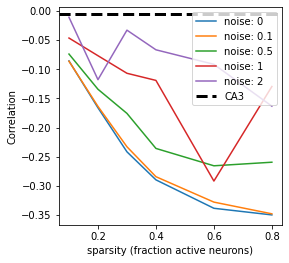

In [63]:
plt.figure(figsize=(4,4))
plt.xlabel("sparsity (fraction active neurons)")
plt.ylabel("Correlation")

for noise in noise_levels:
    idxs = np.where(np.asarray(CA1_data['noise_level'])==noise)
    sparsitites = np.asarray(CA1_data['sparsity'])[idxs]
    correlations = np.asarray(CA1_data['retr_correlations'])[idxs]
    distances = np.asarray(CA1_data['pfc_distances'])[idxs]
    binned_corr = []
    for i,CA1_DD in enumerate(correlations):
        binned_corr.append(binned_statistic(distances[i],CA1_DD,statistic='mean',bins=10)[0])
    min_corr_l = [min(i) for i in binned_corr]
    
    plt.plot(sparsitites,min_corr_l,label=f'noise: {noise}')

# CA3
binned_corr = binned_statistic(CA3_data['pfc_distances'],CA3_data['correlations'],statistic='mean',bins=10)[0]
plt.axhline(y=min(binned_corr),linestyle='--',linewidth=3,c='k',label='CA3')

plt.legend()